In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size=(len(itos))
vocab_size

27

In [6]:
#buidling the dataset
block_size = 3
def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] +[ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])



In [7]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed), generator = g)
W1 = torch.randn((n_embed*block_size,n_hidden), generator = g) * (5/3)/((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

parameters = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


11897


In [8]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    #making a batch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 +b1
    
    h = torch.tanh(hpreact)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits,Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<10000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    #stats
    if i %1000 ==0:
        print(f'{loss.item():4f}')
    lossi.append(loss.log10().item())










3.317901
2.143759
2.359609
2.112541
2.111602
2.223357
2.105736
2.418330
1.958908
2.145953
2.191045
1.878797
2.068082
2.160351
2.584632
1.942704
2.298980
2.211475
1.983394
2.395520


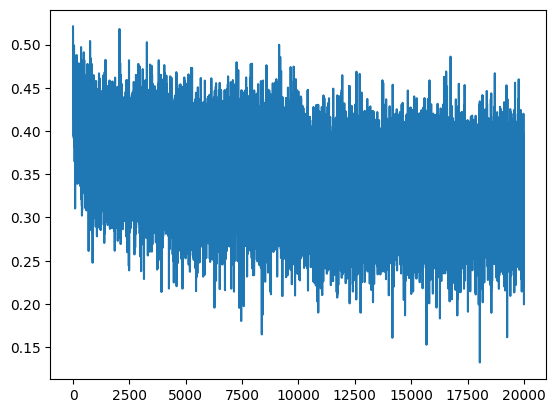

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad()
def split_loss(split):
    x,y ={
        'train':(Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')



train 2.1520614624023438
val 2.1725282669067383


In [11]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1,-1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)

        ix = torch.multinomial(probs,num_samples=1,generator=g).item()

        context = context[1:] + [ix]

        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))



carmah.
ambrilli.
kimri.
reetlanna.
sane.
rahnel.
amerync.
kaqhi.
nellara.
chaiiv.
kaleigh.
ham.
join.
quinn.
saline.
liveni.
waler.
giearisi.
jace.
pirra.


we need to take care of initial loss, we can scale down the parameters, and bring them close to 0 so we have less initial loss, and aalso we dont want majority of the tanhs to be -1 and 1 as that will make the gradeint at that neuron to be 0, and hence the neuron wont learn, so we have to scale the paramters befor ethat layer accordingly



Now how to set theses scales for parameters?


Batch Normalisation: we want our hidden should be roughly gaussian